### Libraries

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import random

from sklearn import model_selection

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

### Config Files

In [4]:
base_path = '../input/version-8-indian-dance-forms/IndianDanceForms2'
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))
valid_df = pd.read_csv(os.path.join(base_path, 'valid.csv'))
valid_dir = os.path.join(base_path, 'test')
test_df['target'] = ['manipuri']*len(test_df)
if not os.path.isdir('output'):
    os.mkdir('output')
ouput_dir = 'output'

idx_class_labels = {
    0: 'bharatanatyam',
    1: 'kathak', 
    2: 'kathakali',
    3: 'kuchipudi',
    4: 'manipuri',
    5: 'mohiniyattam',
    6: 'odissi',
    7: 'sattriya'
}
class_idx_labels = {
    'bharatanatyam': 0,
    'kathak': 1,
    'kathak ': 1,
    'kathakali': 2,
    'kuchipudi': 3,
    'manipuri': 4,
    'mohiniyattam': 5,
    'odissi': 6,
    'sattriya': 7
}

num_classes = len(idx_class_labels.items())
val_size = 0.1
## Model Config
torch.manual_seed(10)

## Setting seeds for deterministic results

In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Utility Functions

In [8]:
def show_sample(img, target=None):
    if target:
        print("Label" ,decode_target(int(target), text_labels=True))
    plt.imshow(img.permute(1, 2, 0))

def show_difference(img1, target1, img2, target2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.set_title("Before Transformation")
    ax1.imshow(img1.permute(1, 2 ,0))
    ax2.set_title("After Transformation")
    ax2.imshow(img2.permute(1, 2 ,0))
    
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
        
def encode_label(label):
    idx = class_idx_labels[label] 
    return idx

def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return idx_class_labels[target]
    else:
        return target
## Example
print(encode_label('kathakali'))
print( decode_target(2, text_labels=True))

2
kathakali


## Creating Dataset and Dataloaders
### Now we will Create custom dataset by extending pytorch Dataset class. We also add provision for adding transformers.

In [9]:
class IndianDanceForms(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['Image'], row['target']
        img = Image.open(os.path.join(self.train_dir, img_id))
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

### Applying Transformations

In [10]:
padding = (10, 15, 20, 30)
train_transform = transforms.Compose([
                                transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(degrees=(-10,+10)),
                                transforms.RandomAffine(0, translate=None, scale=(0.9, 1.1), shear=1, resample=False, fillcolor=0),
                                transforms.Pad(padding, fill=0, padding_mode='reflect'),
                                transforms.Resize(size=(224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
valid_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
train_ds = IndianDanceForms(train_df, train_dir, train_transform)
valid_ds = IndianDanceForms(valid_df, valid_dir, valid_transform)
print(len(train_ds), len(valid_ds))

1335 156


## Creating Dataloaders

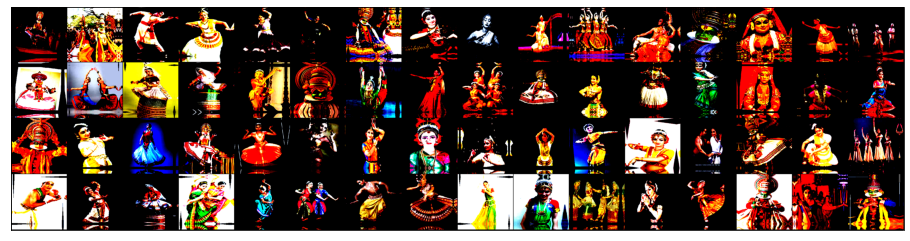

In [11]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
show_batch(train_dl)

## Building Model

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):
    
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss
    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
class DanceFormModel(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = models.wide_resnet50_2(pretrained=True)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, 8),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True


In [15]:
model = DanceFormModel()

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/checkpoints/wide_resnet50_2-95faca4d.pth


### Checking how each batch goes through model

In [16]:
def try_batch(dl):
    for images, labels in dl:  
        print(images.shape)
        out = model(images)
        print(out.shape)
        print(out[0])
        break
try_batch(train_dl)    

torch.Size([64, 3, 224, 224])
torch.Size([64, 8])
tensor([-2.0482, -2.2560, -2.0558, -2.2511, -2.1830, -2.0288, -1.8814, -1.9921],
       grad_fn=<SelectBackward>)


## Training and Evaluating

In [17]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0, grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):
    history = []
    
    valid_loss_min = np.Inf
    valid_acc_max = 0
    model_file_name = 'indian_dance_form.pt'
    model_file_name2 = 'indian_dance_form_max_acc.pt'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.00001)
                         
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):
            
            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
            
            
        result = evaluate(model, valid_loader)
        ########### Early Stopping ##############                                         
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history                                
                                                 
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

## Initializing Device also Loading Data and Model to device

In [18]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [19]:
device = get_device()
## Loading data to devide
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
## Loading model to device
model = to_device(DanceFormModel(), device)
## lets try passing a batch to model again
try_batch(train_dl)

True
torch.Size([64, 3, 224, 224])
torch.Size([64, 8])
tensor([-2.2419, -2.0804, -2.0764, -1.8959, -2.1611, -2.0342, -2.0667, -2.1144],
       device='cuda:0', grad_fn=<SelectBackward>)


In [20]:
torch.cuda.empty_cache()

# Training

In [23]:
## Hyper Parameters
max_epochs_stop = 10
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 2
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model, valid_dl)

{'val_loss': 0.22546347975730896, 'val_acc': 0.9241071343421936}

In [24]:
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.9417, learning_rate: 0.0001, train_loss: 0.2173, val_loss: 0.1164, val_acc: 0.9673


100%|██████████| 21/21 [00:20<00:00,  1.04it/s]


Epoch [1],train_accu: 0.9603, learning_rate: 0.0001, train_loss: 0.1417, val_loss: 0.0300, val_acc: 1.0000
VAL LOSS MIN 0.030047152191400528
VAL ACC MAX 1.0


## Visualize

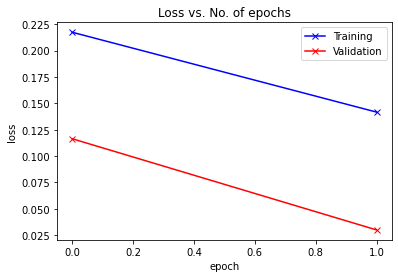

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

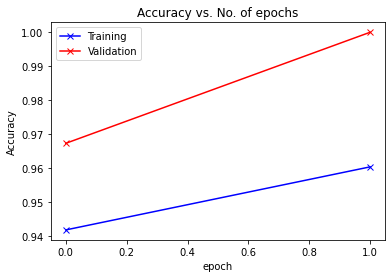

In [26]:
def plot_accuracy(history):
        
    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx')
    plt.plot(val_accu, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracy(history)

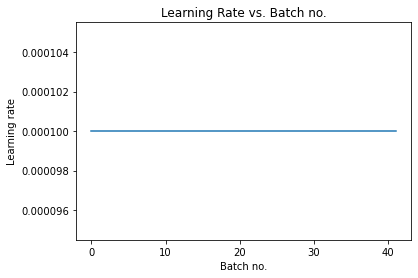

In [27]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)

Prediction:  5 mohiniyattam
Label mohiniyattam


'mohiniyattam'

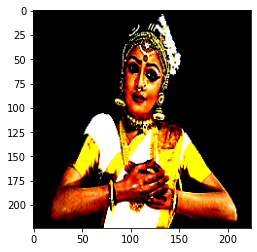

In [29]:
### Predict Single Images
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    _, prediction = torch.max(preds.cpu().detach(), dim=1)
    print("Prediction: ", int(prediction), decode_target(int(prediction), text_labels=True))
    show_sample(image, prediction)
    return decode_target(int(prediction), text_labels=True)
    
predict_single(valid_ds[1][0])